In [1]:


%matplotlib inline
import torch
import torch.nn as nn
from torch.utils import benchmark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
_FIG_SIZE=(6,5)
# _FNAME_SUFFIX = "hector_second_run_my_run"
# _FNAME_SUFFIX = "hector_second_run_my_run"
_FNAME_SUFFIX = "hector_nice-15"

# from condensed_sparsity.models import LinearCondensed


In [2]:
import pickle
threads = 4
device = "gpu"
compiler = "inductor"
dtype="torch.float32"
file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"
with open(f"../{file_name}", "rb") as handle:
    compare = pickle.load(handle)
print(compare)


[---------------------------------------------------------------------------------------------------- Sparsity 99 with 4 threads using compilation strategy inductor and dtype torch.float32 on device cuda. ----------------------------------------------------------------------------------------------------]
                     |  Dense benchmark - Compiled - backend inductor  |   FFI   |  FFI TP  |  FFI TP (self)  |  Structured sparsity compiled with backend - inductor  |  structured + csr with backend inductor  |  csr only compiled with backend - inductor  |  Fine-grained + structured with backend inductor
4 threads: -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
      2048   x 3072  |                      790.2                      |  440.8

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: "DejaVu Sans"
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: "DejaVu Sans"


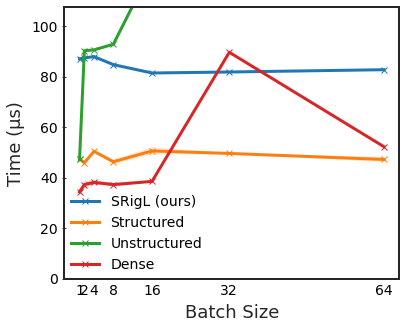

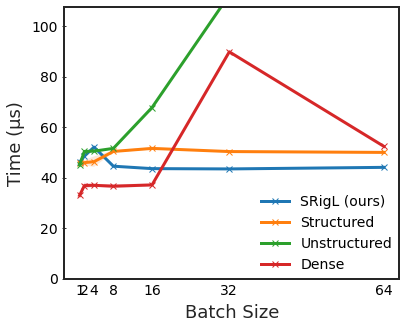

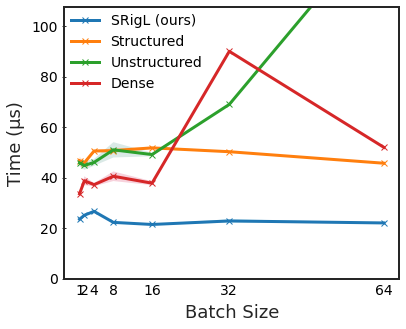

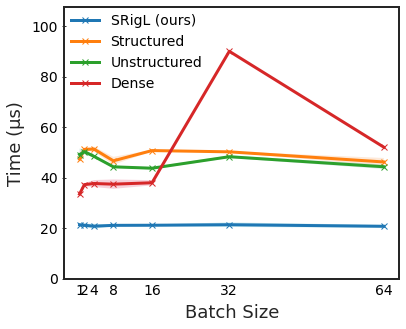

In [3]:
import re
import pandas as pd
import numpy as np
from math import log2
plt.style.use("./plt_plot_style.mplstyle")
target_descriptions = {
    "FFI TP (self)": "SRigL (ours)",
    "Structured sparsity compiled with backend - inductor": "Structured",
    "csr only compiled with backend - inductor": "Unstructured",
    "Dense benchmark - Compiled - backend inductor": "Dense",
    # "Vmap - eager"
}
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": []
}


_COLOURS = sns.color_palette("tab10").as_hex()
import pickle
for threads in [4,]:
# threads = 2
    device = "gpu"
    compiler = "inductor"
    dtype="torch.float32"
    file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"
    with open(f"../{file_name}", "rb") as handle:
        compare = pickle.load(handle)
    # print(compare)

    _y_lim = None
    # fig, axs = plt.subplots(2, 2)
    # ax_idx = 0
    # row_idx = 0
    for _sparsity in [80, 90, 95, 99]:
        data = {
            "sparsity": [],
            "batch_size": [],
            "num_features": [],
            "time": [],
            "std": [],
            "description": []
        }
        # _sparsity = 99
        for measurement in compare._results:
            sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
            sparsity = sparsity_match.groups()[0]

            thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
            threads = thread_match.groups()[0]
            desc = measurement.description
            if int(sparsity) not in [_sparsity,]:
                continue
            if desc not in target_descriptions.keys():
                continue
            # if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) != 95:
            #     continue
            data["description"].append(target_descriptions[desc])
            data["sparsity"].append(int(sparsity))
            batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
            data["batch_size"].append(int(batch))
            data["num_features"].append(int(num_features))
            data["time"].append(measurement.median*1e6)
            data["std"].append(np.std(measurement.times)*1e6)
        df = pd.DataFrame(data)
        _DESC_ORDER = list(target_descriptions.values())
        # df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
        df = df.sort_values(by="batch_size", ascending=True)
        fig, ax = plt.subplots(figsize=_FIG_SIZE)
        _max_batch=64
        df = df.loc[df["batch_size"]<=_max_batch]  # TODO: Also sort by desc?
        lines = ["solid", "dashed", "dashdot", "dotted"]
        for i, d in enumerate(_DESC_ORDER):
            colour = _COLOURS[i]
            for ii, s in enumerate(df["sparsity"].unique()):
                line = lines[ii]
                df_slice = df.loc[(df["sparsity"] == s) & (df["description"]==d)]
                # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
                if len(df_slice) > 0:
                    ax.plot(df_slice["batch_size"], df_slice["time"], label=f"{d}", marker="x", ls=line, color=colour)
                    ax.fill_between(
                        df_slice["batch_size"],
                        df_slice["time"]+df_slice["std"],
                        df_slice["time"]-df_slice["std"],
                        alpha=0.2
                    )
        y_max = df.loc[df["description"]=="Dense"]["time"].max() 
        if _y_lim is None:
            _y_lim = y_max + y_max * 0.2
        plt.ylim(top=_y_lim, bottom=0)
        plt.legend()
        plt.ylabel("Time (\u03bcs)")
        plt.xlabel("Batch Size")
        ax.set_xticks([2**i for i in range(int(log2(_max_batch*2)))])
        # plt.grid(True, which="both")

        # plt.title(f"{_sparsity}% sparsity {threads} threads")
        # ax.set_xscale("log")
        # ax.set_yscale("log")
        plt.show()
        fig.savefig(f"../figs/threads-{threads}-sparsity-{_sparsity}-device{device}.png", dpi=400, transparent=False)
        fig.savefig(f"../figs/threads-{threads}-sparsity-{_sparsity}-device{device}.pdf", dpi=600, transparent=False)


In [4]:
def remove_outliers(df):
    for i, row in df.iterrows():
        q75, q25 = np.percentile(row["times"], [75 ,25])
        # q75, q25 = np.percentile(row["times"], [49, 50])
        
        iqr = q75 - q25
        org_median = row["time"]
        org_std = row["std"]
        updated_times = [t for t in row["times"] if (t < 1.5*iqr+q75) or (t > q25-1.5*iqr)]
        # updated_times = [t for ii,t in enumerate(row["times"]) if ii >=3]
        # updated_times = [t for ii,t in enumerate(row["times"]) if t<1000]
        print(f"dropped {len(row['times'])-len(updated_times)} times")
        updated_std = np.std(updated_times)
        updated_time = np.median(updated_times)
        # df.loc[i,"times"] = updated_times
        print(f"ORIG STD: {org_std}, updated: {updated_std}")
        df.loc[i,"std"] = updated_std
        df.loc[i,"time"] = updated_time
            # print(f"Updated median: {org_median} -> {df.iloc[i]['time']}, {updated_time}")
            # print(f"Updated std: {org_std} -> {df.iloc[i]['std']}")
            # print(f"iqr: {iqr}")
        return df


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: "DejaVu Sans"


Plotting 0, 0
max std: 7.597818863052924
dropped 0 times
ORIG STD: 2.240719963456643, updated: 2.240719963456614
max std: 7.597818863052924
Plotting 0, 1
max std: 3.3037592348245584
dropped 0 times
ORIG STD: 1.1917413935817927, updated: 1.1917413935818093
max std: 3.3037592348245584
Plotting 1, 0
max std: 2.07807679938607
dropped 0 times
ORIG STD: 0.9712885961560603, updated: 0.9712885961560228
max std: 2.07807679938607
Plotting 1, 1
max std: 2.0356551472411195
dropped 0 times
ORIG STD: 0.5974492600580447, updated: 0.5974492600580235
max std: 2.0356551472411195


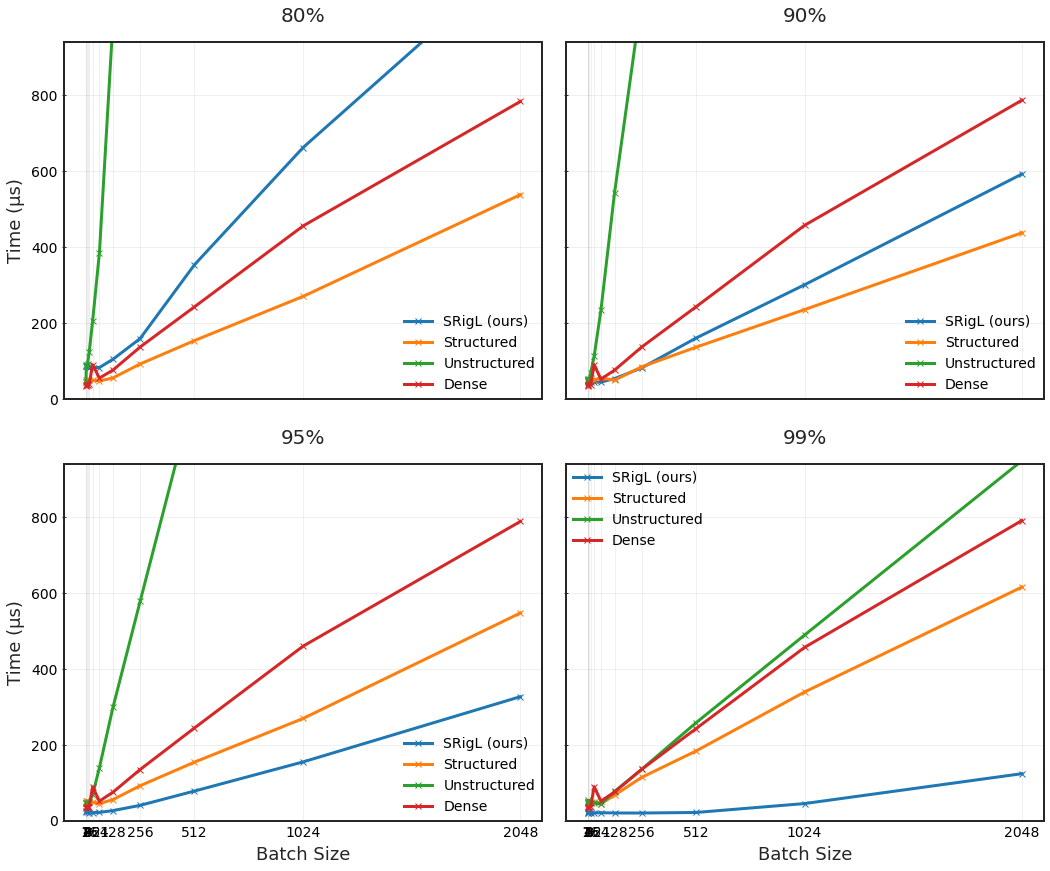

Plotting 0, 0
max std: 6.093771483135715
dropped 0 times
ORIG STD: 6.093771483135715, updated: 6.093771483135701
max std: 6.093771483135701
Plotting 0, 1
max std: 5.6268720129824406
dropped 0 times
ORIG STD: 5.6268720129824406, updated: 5.626872012982428
max std: 5.626872012982428
Plotting 1, 0
max std: 2.045790081253016
dropped 0 times
ORIG STD: 0.9688705727722172, updated: 0.9688705727722393
max std: 2.045790081253016
Plotting 1, 1
max std: 11.66050750154582
dropped 0 times
ORIG STD: 11.66050750154582, updated: 11.660507501545816
max std: 11.660507501545816


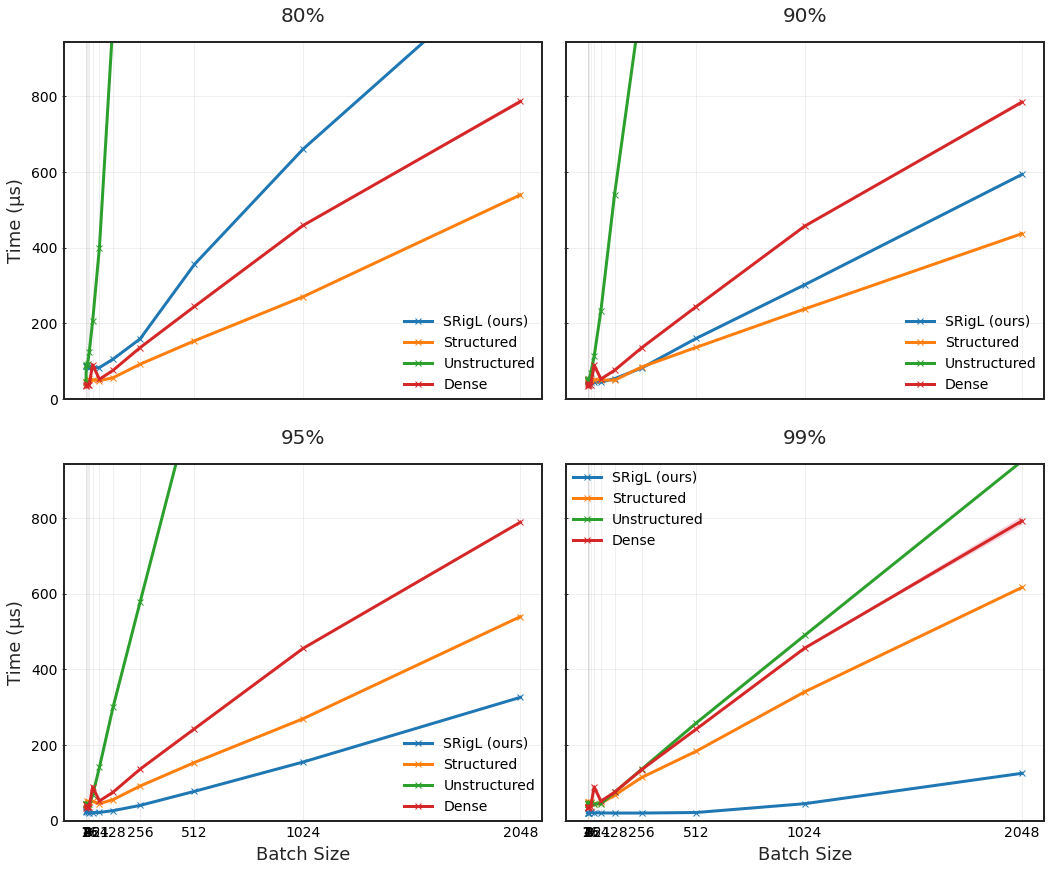

Plotting 0, 0
max std: 7.2199396822697715
dropped 0 times
ORIG STD: 6.798935824818374, updated: 6.798935824818364
max std: 7.2199396822697715
Plotting 0, 1
max std: 2.268371875977171
dropped 0 times
ORIG STD: 1.1235154330099022, updated: 1.1235154330098895
max std: 2.268371875977171
Plotting 1, 0
max std: 3.0330212811433137
dropped 0 times
ORIG STD: 1.137954585377975, updated: 1.1379545853779713
max std: 3.0330212811433137
Plotting 1, 1
max std: 6.525560096421722
dropped 0 times
ORIG STD: 6.525560096421722, updated: 6.52556009642171
max std: 6.52556009642171


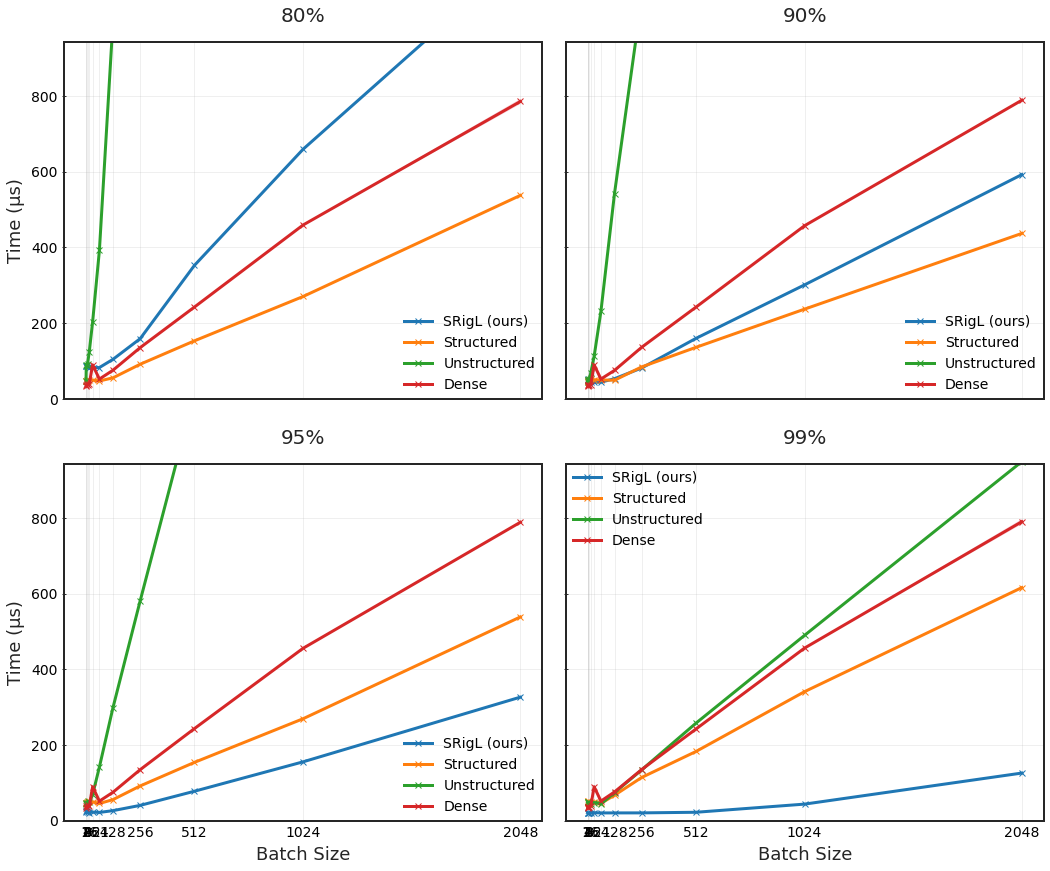

Plotting 0, 0
max std: 10.064139299986225
dropped 0 times
ORIG STD: 6.458270779186697, updated: 6.458270779186695
max std: 10.064139299986225
Plotting 0, 1
max std: 9.690543346931637
dropped 0 times
ORIG STD: 5.193052056611536, updated: 5.193052056611537
max std: 9.690543346931637
Plotting 1, 0
max std: 6.018505690578726
dropped 0 times
ORIG STD: 6.018505690578726, updated: 6.018505690578741
max std: 6.018505690578741
Plotting 1, 1
max std: 13.788077723167776
dropped 0 times
ORIG STD: 13.788077723167776, updated: 13.788077723167776
max std: 13.788077723167776


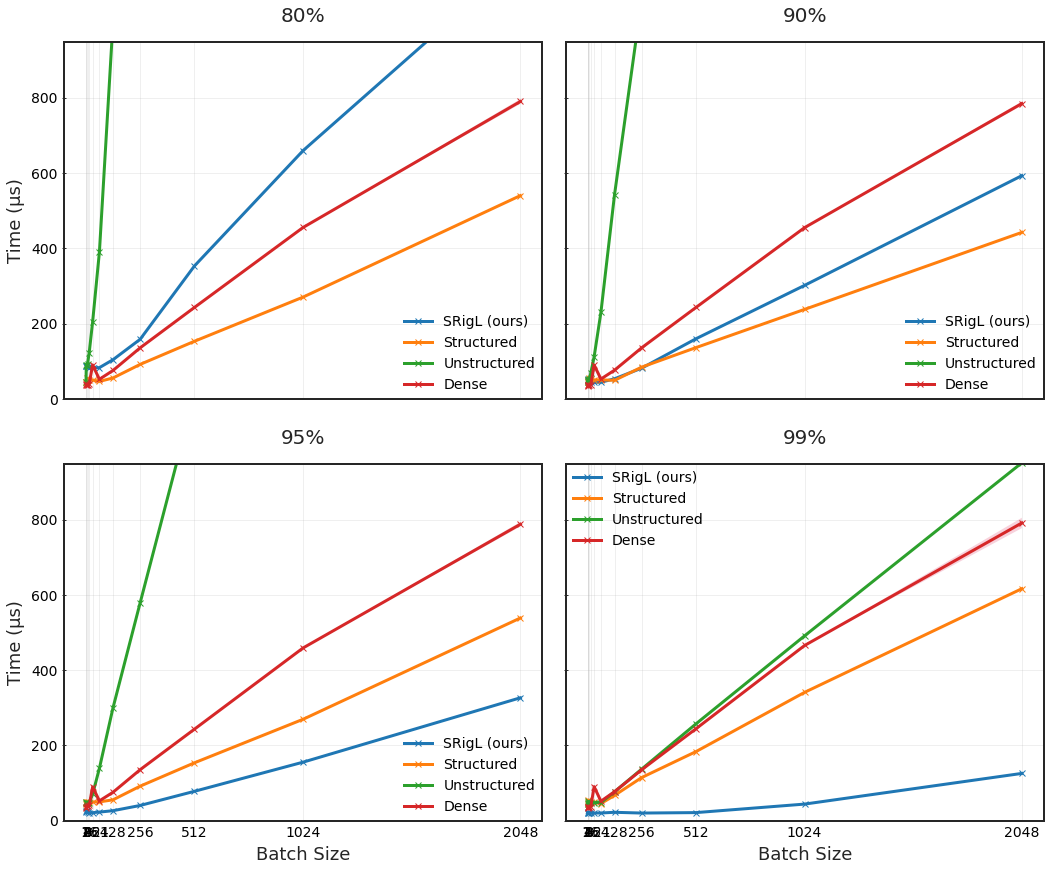

Plotting 0, 0
max std: 13.603578835998826
dropped 0 times
ORIG STD: 1.3783782995981504, updated: 1.3783782995981146
max std: 13.603578835998826
Plotting 0, 1
max std: 1.8818041551102278
dropped 0 times
ORIG STD: 1.8818041551102278, updated: 1.881804155110256
max std: 1.881804155110256
Plotting 1, 0
max std: 1.914243164215309
dropped 0 times
ORIG STD: 1.0360447442614498, updated: 1.0360447442614231
max std: 1.914243164215309
Plotting 1, 1
max std: 2.0142568133909604
dropped 0 times
ORIG STD: 0.3485712222375678, updated: 0.3485712222375657
max std: 2.0142568133909604


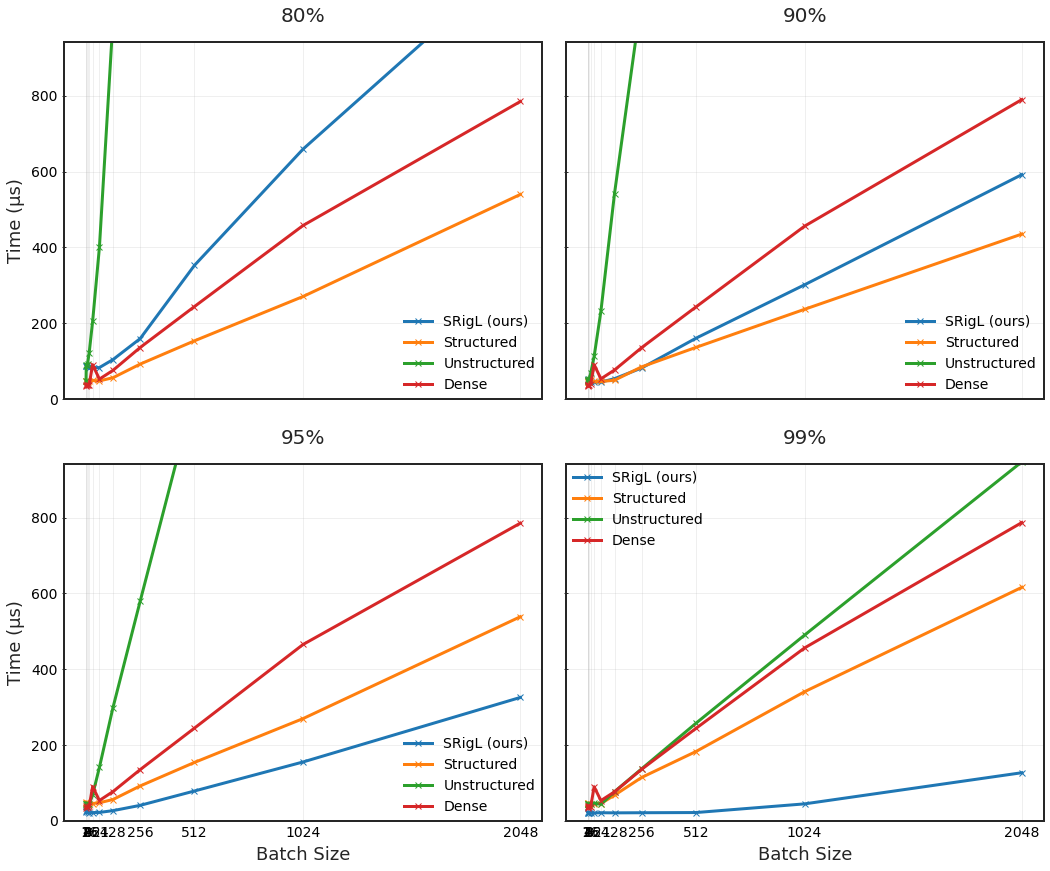

In [5]:
import re
import pandas as pd
import numpy as np
from math import log2
plt.style.use("./plt_plot_style.mplstyle")
# target_descriptions = {
#     "Fine-grained + structured with backend inductor": "SRigL (ours)",
#     "Structured sparsity compiled with backend - inductor": "Structured",
#     # "structured + csr with backend inductor": "Structured+csr",
#     "csr only compiled with backend - inductor": "Unstructured",
#     "Dense benchmark - Compiled - backend inductor": "Dense",
#     # "Vmap - eager"
# }

target_descriptions = {
    "FFI TP (self)": "SRigL (ours)",
    "Structured sparsity compiled with backend - inductor": "Structured",
    "csr only compiled with backend - inductor": "Unstructured",
    "Dense benchmark - Compiled - backend inductor": "Dense",
    # "Vmap - eager"
}
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": []
}


_COLOURS = sns.color_palette("tab10").as_hex()
import pickle
for threads in [1,2,4,8,16]:
# threads = 2
    device = "gpu"
    compiler = "inductor"
    dtype="torch.float32"
    file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"
    with open(f"../{file_name}", "rb") as handle:
        compare = pickle.load(handle)
    # print(compare)

    _y_lim = None
    fig, axs = plt.subplots(2, 2, figsize=[f * 2.5 for f in _FIG_SIZE],sharex=True, sharey=True)
    col_idx = 0
    row_idx = 0
    for _s_idx,_sparsity in enumerate([80, 90, 95, 99]):
        col_idx = 0
        if _s_idx > 1:
            row_idx = 1
        if _s_idx % 2 != 0:
            col_idx = 1
        print(f"Plotting {row_idx}, {col_idx}")
        data = {
            "sparsity": [],
            "batch_size": [],
            "num_features": [],
            "time": [],
            "std": [],
            "description": [],
            "times": []
        }
        # _sparsity = 99
        for measurement in compare._results:
            sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
            sparsity = sparsity_match.groups()[0]

            thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
            threads = thread_match.groups()[0]
            desc = measurement.description
            if int(sparsity) not in [_sparsity,]:
                continue
            if desc not in target_descriptions.keys():
                continue
            # if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) != 95:
            #     continue
            data["description"].append(target_descriptions[desc])
            data["sparsity"].append(int(sparsity))
            batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
            data["batch_size"].append(int(batch))
            data["num_features"].append(int(num_features))
            data["time"].append(measurement.median*1e6)
            data["std"].append(np.std(measurement.times)*1e6)
            data["times"].append([t*1e6 for t in measurement.times])
        df = pd.DataFrame(data)
        print(f"max std: {df['std'].max()}")
        df = remove_outliers(df)
        print(f"max std: {df['std'].max()}")
        _DESC_ORDER = list(target_descriptions.values())
        # df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
        df = df.sort_values(by="batch_size", ascending=True)
        # fig, ax = plt.subplots(figsize=_FIG_SIZE)
        _max_batch=2048
        df = df.loc[df["batch_size"]<=_max_batch]  # TODO: Also sort by desc?
        lines = ["solid", "dashed", "dashdot", "dotted"]
        for i, d in enumerate(_DESC_ORDER):
            colour = _COLOURS[i]
            for ii, s in enumerate(df["sparsity"].unique()):
                line = lines[ii]
                df_slice = df.loc[(df["sparsity"] == s) & (df["description"]==d)]
                # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
                if len(df_slice) > 0:
                    axs[row_idx, col_idx].plot(df_slice["batch_size"], df_slice["time"], label=f"{d}", marker="x", ls=line, color=colour)
                    axs[row_idx, col_idx].fill_between(
                        df_slice["batch_size"],
                        df_slice["time"]+df_slice["std"],
                        df_slice["time"]-df_slice["std"],
                        alpha=0.2
                    )
        y_max = df.loc[df["description"]=="Dense"]["time"].max() 
        if _y_lim is None:
            _y_lim = y_max + y_max * 0.2
        axs[row_idx, col_idx].set_ylim(top=_y_lim, bottom=0)
        axs[row_idx, col_idx].legend()
        plt.ylabel("Time (\u03bcs)")
        plt.xlabel("Batch Size")
        axs[row_idx, col_idx].set_xticks([2**i for i in range(int(log2(_max_batch*2)))])
        # axs[row_idx, col_idx].set_title(f"Sparsity {_sparsity}%", fontsize=20)
        axs[row_idx, col_idx].set_title(f"{_sparsity}%", fontsize=20)
        axs[row_idx, col_idx].grid(True, alpha=0.25)
        
    for ax in axs.flat:
        ax.set(xlabel="Batch Size", ylabel="Time (\u03bcs)")

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        

        
        # plt.grid(True, which="both")

        # plt.title(f"{_sparsity}% sparsity {threads} threads")
        # ax.set_xscale("log")
        # ax.set_yscale("log")
    plt.grid(True, alpha=0.25)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"../figs/multi_plot_threads-{threads}-device-{device}.png", dpi=400, transparent=False)
    fig.savefig(f"../figs/multi_plot_threads-{threads}-device-{device}.pdf", dpi=600, transparent=False)


3
3
2
3


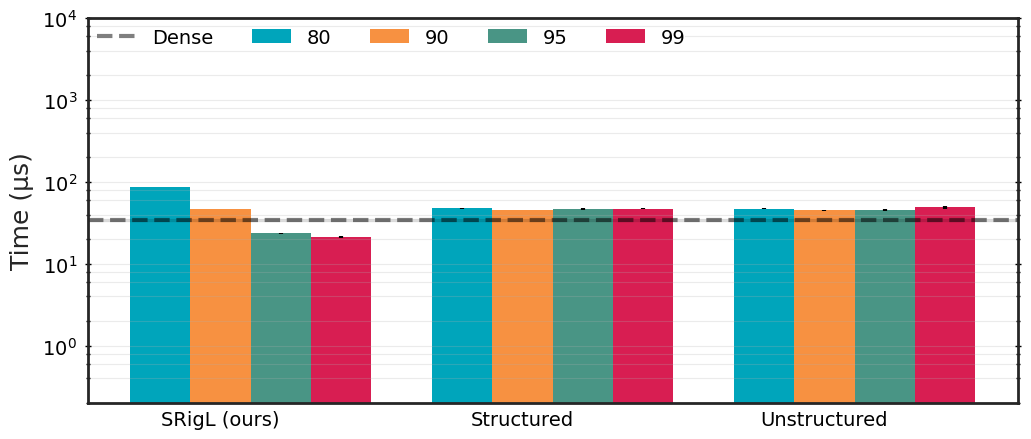

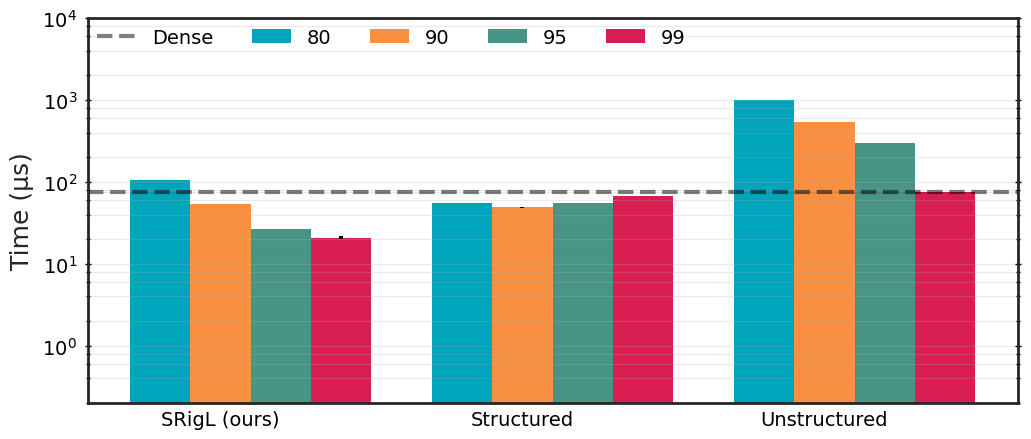

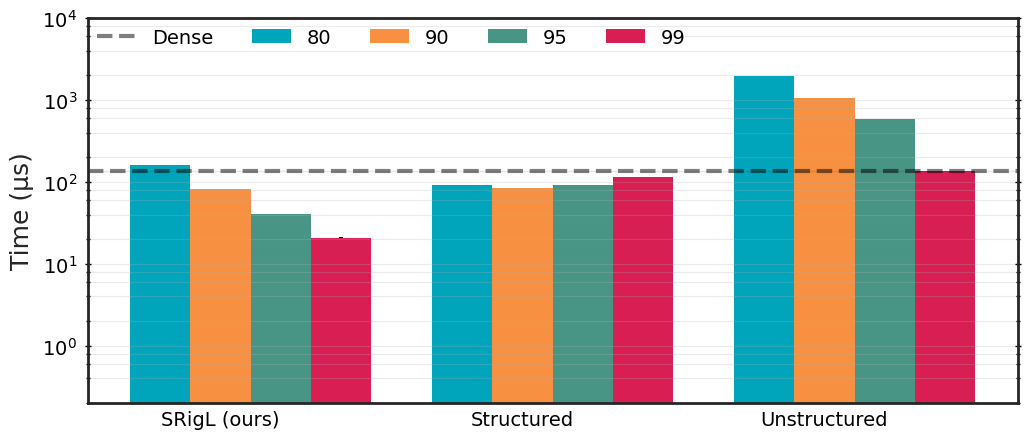

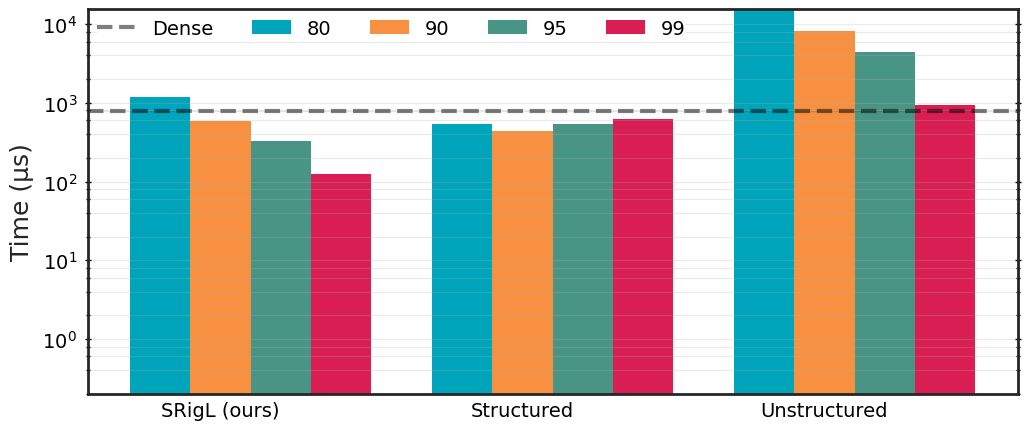

In [40]:
import re
import pandas as pd
import numpy as np
plt.style.use("./plt_plot_style_y_ticks.mplstyle")
# plt.style.use("default")


import pickle
# for threads in [1,2,4,8,16]:
for batch_size in [1, 128, 256, 2048]:
    for threads in [4,]:
        device = "gpu"
        compiler = "inductor"
        dtype="torch.float32"
        # batch_size=2048
        file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"    
        with open(f"../{file_name}", "rb") as handle:
            compare = pickle.load(handle)


        data = {
            "sparsity": [],
            "batch_size": [],
            "num_features": [],
            "time": [],
            "std": [],
            "description": [],
            "times":[]
        }
        for measurement in compare._results:
            sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
            sparsity = sparsity_match.groups()[0]

            thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
            threads = thread_match.groups()[0]
            desc = measurement.description
            if desc not in target_descriptions.keys():
                continue
            data["description"].append(target_descriptions[desc])
            data["sparsity"].append(int(sparsity))
            batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
            data["batch_size"].append(int(batch))
            data["num_features"].append(int(num_features))
            data["time"].append(measurement.median*1e6)
            data["times"].append([t*1e6 for t in measurement.times])
            data["std"].append(np.std(measurement.times)*1e6)


        df = pd.DataFrame(data)
        df = df.reset_index()
        df = df.loc[df["batch_size"]==batch_size].reset_index()
        # if threads == "16":

        min_runs = np.inf
        for t in df['times']:
            if len(t)<min_runs:
                min_runs=len(t)
        print(min_runs)
        _DESC_ORDER = list(target_descriptions.values())
        df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
        df = df.sort_values(by="batch_size", ascending=True)
        x = np.arange(3)  # the label locations
        width = 0.2  # the width of the bars
        multiplier = 0

        fig, ax = plt.subplots(figsize=(_FIG_SIZE[0]*2, _FIG_SIZE[1]))  
        df_one_sample = df.loc[(df["batch_size"]==batch_size) & (df["description"]!="Dense")]
        df_one_sample = df_one_sample.sort_values(by=["description"], ascending=True)
        for sparsity in [ 80, 90, 95, 99]:
            df_slice = df_one_sample.loc[df_one_sample['sparsity']==sparsity]
            offset = width * multiplier
            rects = ax.bar(x + offset, df_slice["time"], width, label=sparsity, align="center", yerr=df_slice["std"])
            multiplier += 1
        dense_time = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==batch_size)]["time"].item()
        std = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==batch_size)]["std"].item()
        plt.axhline(y=dense_time, color='black', linestyle='--', label='Dense', alpha=0.5)
        # plt.fill_between([-100, 100], dense_time+std, dense_time-std, alpha=0.1, color="black")
        
        ax.fill_between(ax.get_xlim(), dense_time+std, dense_time-std, alpha=0.1, color="black")
        # _alpha=0.2
        # plt.axhline(y=dense_time+std, color='black', linestyle='--', alpha=_alpha)
        # plt.axhline(y=dense_time-std, color='black', linestyle='--', alpha=_alpha)
        ax.set_ylabel('Time (\u03bcs)')
        ax.set_xticks(x + width, _DESC_ORDER[:-1])
        # ax.legend(title="Sparsity", loc='upper left', ncol=5)
        # ax.legend(loc='upper left', ncol=5, frameon=True)
        leg = ax.legend(loc='upper left', ncol=5, facecolor='White', frameon=True)
        leg.get_frame().set_linewidth(0.0)
        y_max = df.loc[(df["batch_size"]==batch_size)]["time"].max() 
        y_lim = y_max + y_max*0.2
        # y_lim = dense_time + dense_time * 0.2
        # plt.ylim(top=y_lim, bottom=0)
        # plt.ylim(top=200, bottom=0)
        # ax.set_xlim=([0,2])
        ax.margins(0)  
        # plt.yaxis*()
        # plt.tight_layout(pad=0,h_pad=0)
        # plt.grid(axis="y", alpha=0.4)
        # plt.grid(axis="y", alpha=0.25)
    

        fig.show()
        ax.set_yscale("log")
        # plt.yscale("log")
        # plt.tick_params(axis='y', which="minor")
        import matplotlib
        
        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=5) 
        ax.yaxis.set_major_locator(locmaj)
        
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=5)
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
        # ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax.tick_params(axis='both', which="both", reset=True)
        ax.minorticks_on()
        ax.set_yticks([10**i for i in range(5)], size=300, width=300)
        ax.set_yticks([x*10**i for i in range(5) for x in [0.2, 0.4, 0.6, 0.8]], minor=True, size=300, width=100, direction="inout",)
        ax.grid(axis="y", alpha=0.25, which="both")
        # plt.grid(True, alpha=0.25)    # plt.title(f"{threads} threads")
        fig.savefig(f"../figs/grouped-bar-threads-{threads}-device-{device}-batch_size-{batch_size}.png", dpi=600, bbox_inches="tight")
        fig.savefig(f"../figs/grouped-bar-threads-{threads}-device-{device}-batch_size-{batch_size}.pdf", dpi=600, bbox_inches="tight")


None


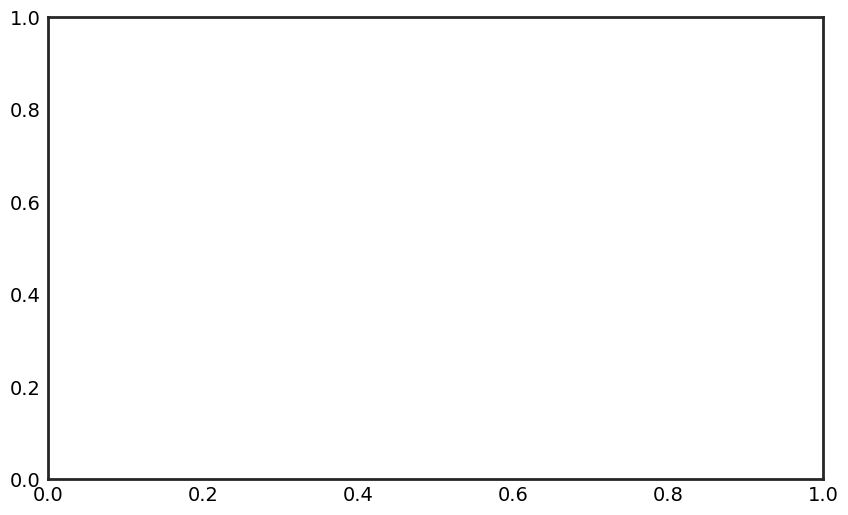

In [22]:
print(plt.tick_params())


In [7]:
[x*10**i for i in range(5) for x in [0.2, 0.4, 0.6, 0.8]]


[0.2,
 0.4,
 0.6,
 0.8,
 2.0,
 4.0,
 6.0,
 8.0,
 20.0,
 40.0,
 60.0,
 80.0,
 200.0,
 400.0,
 600.0,
 800.0,
 2000.0,
 4000.0,
 6000.0,
 8000.0]